In [1]:
%load_ext autoreload
%autoreload 2

# from lib_dpe import *
# import lib_nn as nn
# %config InlineBackend.figure_formats = ['svg']
from lib_nn_dpe import NN_dpe

import matplotlib.pyplot as plt
import numpy as np
from lib_data import *
import time
from IPython import display

In [2]:
load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [3]:
nn = NN_dpe(weights)

In [10]:
acc = []

i = 0

xs = []

for label, img in zip(test_labels, test_images):
#     y = nn.forward_pass(img)
    
    vectors = nn._conv_flattern(img)
    x1 = nn.Gconv.T @ vectors / nn.Gratio
    x1 = x1[::2, :] - x1[1::2, :]
    x1 = x1.T.reshape(20,20,-1)
    
    x1 = nn.relu(x1)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
#     nn.Gconv.T @ vec_list[i]
    
    acc.append( y.argmax() == label)

    if (i+1)%100 == 0:
        display.clear_output(wait=True)
        print(f'i={i}, accuracy={np.mean(acc) * 100:.4f}%')
    i += 1
    

i=9999, accuracy=98.1500%


In [12]:
save_workspace({'xs': xs}, 'mnist_xs_software')

Saving xs(<class 'list'>), to mnist_xs_software.pkl
Saving xs(<class 'list'>), to mnist_xs_software.mat


In [ ]:
N_BIT = 8
image = test_images[0]

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

out_list = []

for i in range(N_BIT):
    out = nn.Gconv.T @ vec_list[i]
    out_list.append( out[::2] - out[1::2] )

result = np.zeros( out_list[0].shape )
for i in range(N_BIT):
    result += out_list[i] * (0x1<<i)

result = result / nn.Gratio / (2**N_BIT -1)
    
x = result.T.reshape(20,20,-1)
plt.imshow(x[:,:,1])
plt.colorbar()

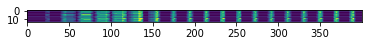

In [241]:
plt.imshow(out)

In [242]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y.argmax())

7


In [182]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
# %config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)

In [183]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default


In [4]:
dut.power_off()

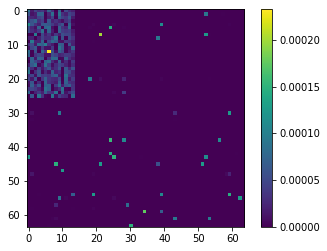

In [185]:
data = a0.pic_read_batch(1, gain=-1 ) / 0.2
plt.imshow(data)
plt.colorbar()

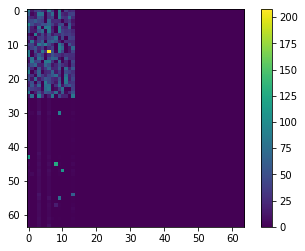

In [198]:
input = [0x1<<i for i in range(64)]
data = a0.pic_dpe_batch(1, input, gain=-1, Vread=0.2, mode=1, 
                        col_en=[0x0000, 0x0000, 0x0000, 0x3fff]) / 0.2
plt.imshow(data * 1e6)
plt.colorbar()

In [184]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK', divisor=2)
drv.clk_config('CK_ARRAY', divisor=2)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [199]:
img_idx = 0

N_BIT = 8
image = test_images[img_idx]

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

vec_list = np.array(vec_list)
vec_list.shape

(8, 26, 400)

In [245]:
ts=time.time()

outputs_dpe_list = []
exp_out_list = []
soft_out_list = []

for vec in vec_list:
    inputs_dpe = []
    for v in vec.T:
        in_dpe = 0

        for i, el in enumerate(v):
            if el:
                in_dpe |= 0x1 << i
#                 print(i)

        inputs_dpe.append(in_dpe)

    # Hardware call
    outputs_dpe = a0.pic_dpe_batch(1, inputs_dpe, gain=-1, mode=1, col_en=[0x0000, 0x0000, 0x0000, 0x3fff])
    outputs_dpe = outputs_dpe[:,:14]
    
    exp_out_list.append(outputs_dpe)
    soft_out_list.append( (nn.Gconv.T @ vec).T )
    
    outputs_dpe_list.append( outputs_dpe[:,::2] - outputs_dpe[:,1::2] )
print(time.time() - ts)

1.113980770111084


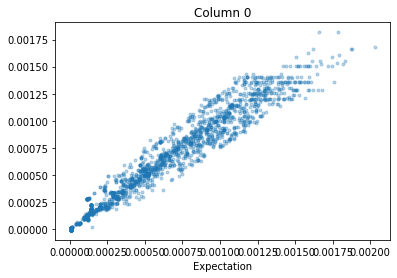

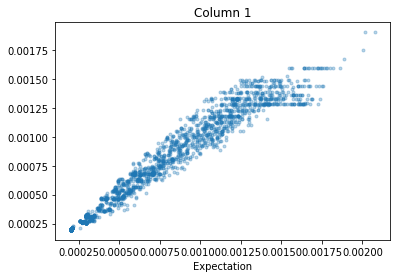

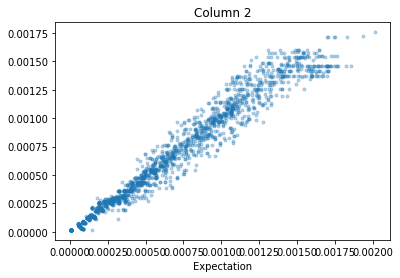

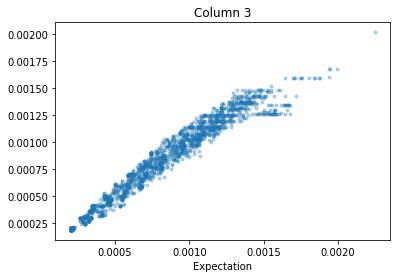

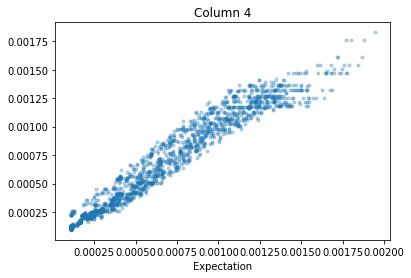

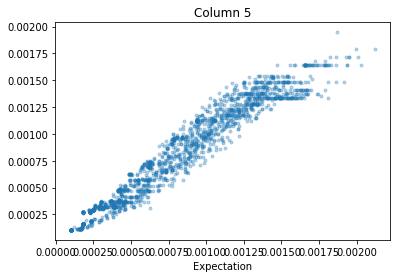

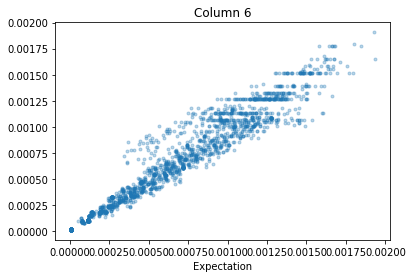

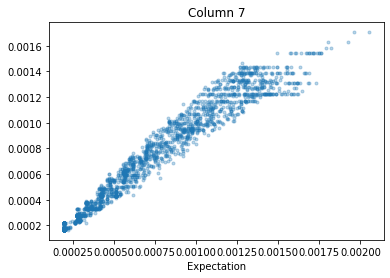

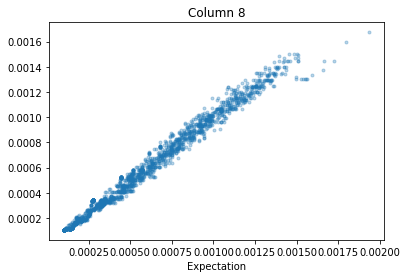

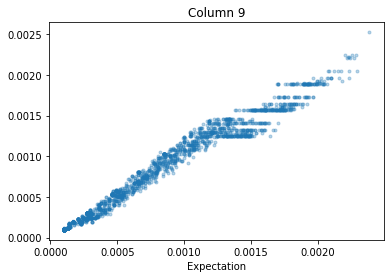

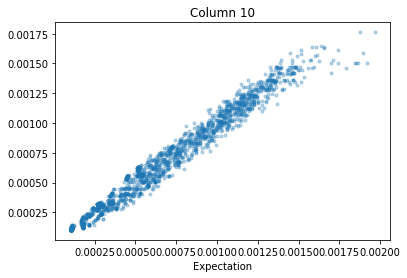

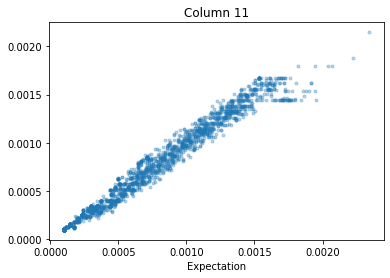

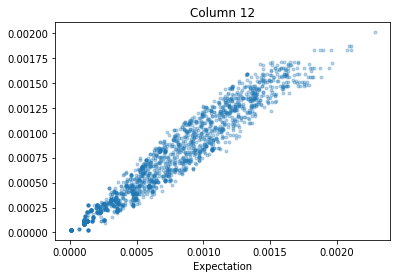

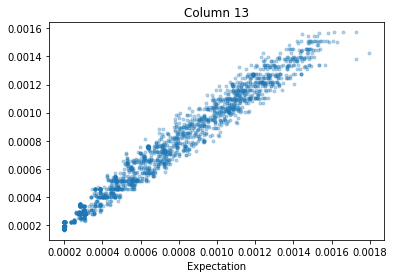

In [253]:
for c in range(14):
    x = []
    y = []
    for soft_out, exp_out in zip(soft_out_list, exp_out_list):
        x += soft_out[:,c].tolist() 
        y += exp_out[:,c].tolist() 
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(x,y, '.', alpha=0.3)
    plt.xlabel('Expectation')

In [247]:
lin_par = []
for c in range(14):
#     plt.figure(c+1)
#     plt.title(f'Column {c}')
    
    x = []
    y = []
    for soft_out, exp_out in zip(soft_out_list, exp_out_list):
        x += soft_out[:,c].tolist() 
        y += exp_out[:,c].tolist() 
    lin_par.append( np.polyfit(y, x, 1))

In [248]:
linear_factors_conv = np.array(lin_par)

In [249]:
linear_factors_conv

array([[ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]])

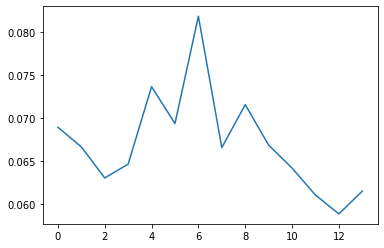

In [213]:
plt.plot( [a[0] for a in lin_par] )

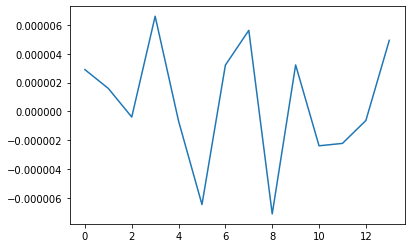

In [214]:
plt.plot( [a[1] for a in lin_par] )

Start read process

In [266]:
img_idx = 5

N_BIT = 8
image = test_images[img_idx]

vectors = nn._conv_flattern(image)

vec_int = np.round(vectors* (2**N_BIT -1))
vec_int = np.array(vec_int, dtype=np.uint32)

vec_list = []

for i in range(N_BIT):
    vec_list.append( (vec_int>>i) & 0x1 )

vec_list = np.array(vec_list)
vec_list.shape

(8, 26, 400)

In [267]:
linear_factors_conv = [
       [ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]]

In [268]:
ts=time.time()

outputs_dpe_list = []
exp_out_list = []
soft_out_list = []

for vec in vec_list:
    inputs_dpe = []
    for v in vec.T:
        in_dpe = 0

        for i, el in enumerate(v):
            if el:
                in_dpe |= 0x1 << i
#                 print(i)

        inputs_dpe.append(in_dpe)

    # Hardware call
    outputs_dpe = a0.pic_dpe_batch(1, inputs_dpe, gain=-1, mode=1, col_en=[0x0000, 0x0000, 0x0000, 0x3fff])
    outputs_dpe = outputs_dpe[:,:14]
    
    for c in range(outputs_dpe.shape[1]):
        outputs_dpe[:,c] = outputs_dpe[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    exp_out_list.append(outputs_dpe)
    soft_out_list.append( (nn.Gconv.T @ vec).T )
    

    
    outputs_dpe_list.append( outputs_dpe[:,::2] - outputs_dpe[:,1::2] )
print(time.time() - ts)

1.1100420951843262


In [269]:
outputs_dpe.shape[1]

14

In [270]:
result = np.zeros( outputs_dpe_list[0].shape )
for i in range(N_BIT):
    result += outputs_dpe_list[i] * (0x1<<i)

result = result / nn.Gratio / (2**N_BIT -1)

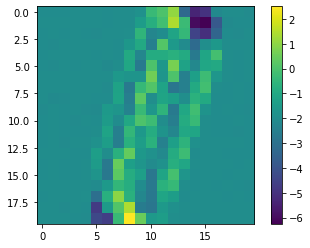

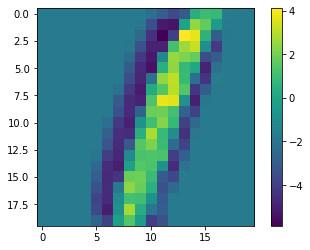

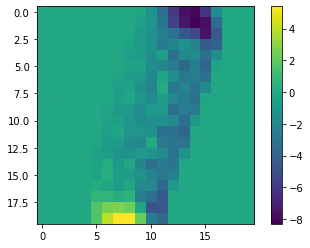

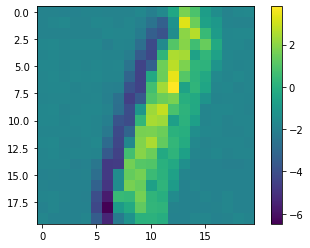

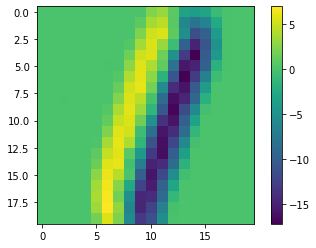

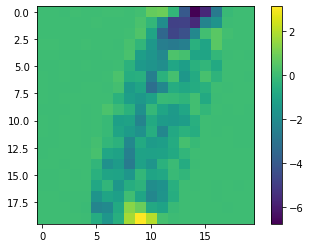

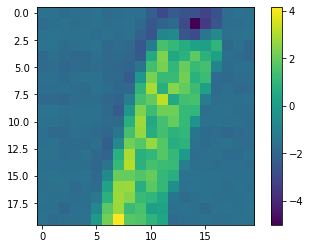

In [271]:
x = result.reshape(20,20,-1)
for i in range(7):
    plt.figure(i)
    plt.imshow(x[:,:,i])
    plt.colorbar()

In [272]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y.argmax())

1


In [273]:
test_labels[img_idx]

1

In [274]:
dut.disconnect()

Serial port disconnected.


In [4]:
from dpe import DPE

In [5]:
dpe = DPE()

Connecting to serial
{'args': (<dpe.DPE object at 0x0EE44D30>,), 'kwargs': {}, 'func': <function DPE.init_dut at 0x0EE54930>}
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Serial disconnected
Serial port disconnected.


In [6]:
g = dpe.read()

AttributeError: 'DPE' object has no attribute 'read'